In [1]:
# libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data 
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

# Neural Net
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Loading Data**

In [2]:
testing_path = "../input/brain-tumor-classification-mri/Testing"
training_path = "../input/brain-tumor-classification-mri/Training"

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])

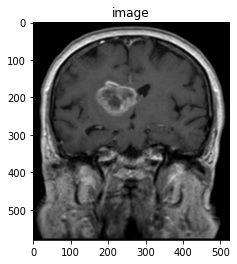

In [4]:
plt.title('image')
image = mpimg.imread("../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(12).jpg")
plt.imshow(image)
plt.show()

In [5]:
train_data = datasets.ImageFolder(training_path, transform=train_transforms)
test_data = datasets.ImageFolder(testing_path, transform=test_transforms)
train_data, val_data = torch.utils.data.random_split(train_data, [2670, 200])

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, shuffle=True)

# **Visualizing Data**

In [7]:
def imgshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

(64, 3, 250, 250)

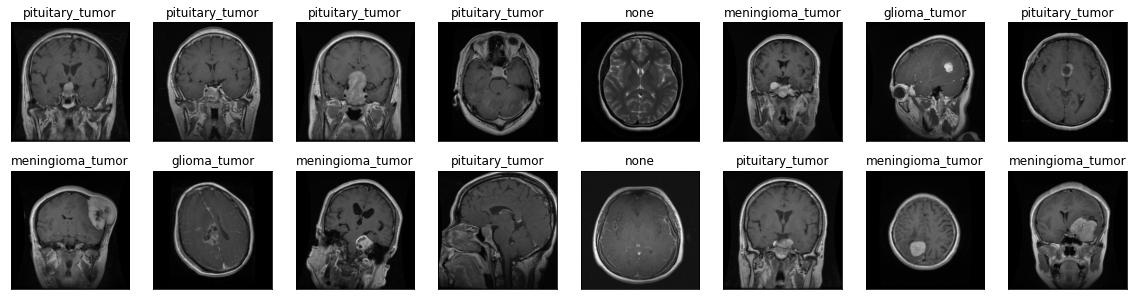

In [9]:
fig = plt.figure(figsize=(20, 5))

classes = ["glioma_tumor", "meningioma_tumor", "none","pituitary_tumor"]

for i in np.arange(16):
    ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
    imgshow(images[i])
    ax.set_title(classes[labels[i]])

# **Building The Network**

In [10]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(10*124*124, 16)
        self.fc2 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = x.view(-1,10*124*124)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = (self.fc2(x))
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=153760, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [12]:
epochs = 30 
min_loss = 100000

for i in range(epochs): 
    train_loss = 0 
    valid_loss = 0 
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*labels.size(0)

    model.eval()
    for images, labels in valid_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        valid_loss += loss.item()*labels.size(0)
        
    total_train_loss = train_loss/len(train_loader)
    total_valid_loss = train_loss/len(valid_loader)
    
    print("\nEpoch {}, \ntraining loss: {} \nvalidation loss: {}".format(i, train_loss, valid_loss))
    if total_valid_loss < min_loss: 
        print("loss decreased {} --> {}".format(min_loss, total_valid_loss))
        torch.save(model.state_dict(), 'model.brain.pt')
        min_loss = total_valid_loss


Epoch 0, 
training loss: 4114.435441732407 
validation loss: 253.59818840026855
loss decreased 100000 --> 1028.6088604331017

Epoch 1, 
training loss: 3133.438234567642 
validation loss: 220.68717765808105
loss decreased 1028.6088604331017 --> 783.3595586419106

Epoch 2, 
training loss: 2976.563980102539 
validation loss: 202.15335083007812
loss decreased 783.3595586419106 --> 744.1409950256348

Epoch 3, 
training loss: 2682.2527685165405 
validation loss: 179.76850128173828
loss decreased 744.1409950256348 --> 670.5631921291351

Epoch 4, 
training loss: 2385.3918108940125 
validation loss: 164.07585954666138
loss decreased 670.5631921291351 --> 596.3479527235031

Epoch 5, 
training loss: 2157.698063015938 
validation loss: 139.01588439941406
loss decreased 596.3479527235031 --> 539.4245157539845

Epoch 6, 
training loss: 1960.8769869804382 
validation loss: 127.1919059753418
loss decreased 539.4245157539845 --> 490.21924674510956

Epoch 7, 
training loss: 1850.557819545269 
validatio

In [13]:
model.load_state_dict(torch.load('model.brain.pt'))

<All keys matched successfully>

# **Testing The Network**

In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval()
for images, labels in test_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    print(pred, correct_tensor, correct)
    
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i]))) 
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

tensor([1, 1, 3, 1, 3, 1, 0, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1,
        3, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 3, 3, 2, 2, 1,
        2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) tensor([False, False,  True, False,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False,  True, False,  True, False,  True,
         True,  True, False,  True,  True, False,  True, False,  True, False,
         True,  True,  True, False,  True,  True,  True, False,  True, False,
         True, False,  True,  True,  True, False, False,  True, False,  True,
        False, False,  True,  True, False, False, False, False, False, False,
        False, False,  True,  True]) [False False  True False  True  True  True  True  True  True  True False
 False False False  True False  True False  True  True  True False  True
  True False  True False  True False  True  True  True False  True  True
  True False  True False  True False  True  True  True Fals